# <center> TOP Verkleg Æfing
### <center> Snúningspendúll (Torsional Pendulum)
<center> *Authors*

In [201]:
using DataFrames, Statistics, CSV
using Measurements, Unitful
using Plots, PlotThemes
using EasyFit, Peaks, Symbolics
using Latexify, LaTeXStrings
using RemoteREPL
@async serve_repl()
plotlyjs();
theme(:dracula)
val(x) = (Measurements.value∘ustrip∘upreferred)(x)
err(x) = (Measurements.uncertainty∘ustrip∘upreferred)(x)

err (generic function with 1 method)

## Gögn

### Gögn 1, mæling á kraft og θ

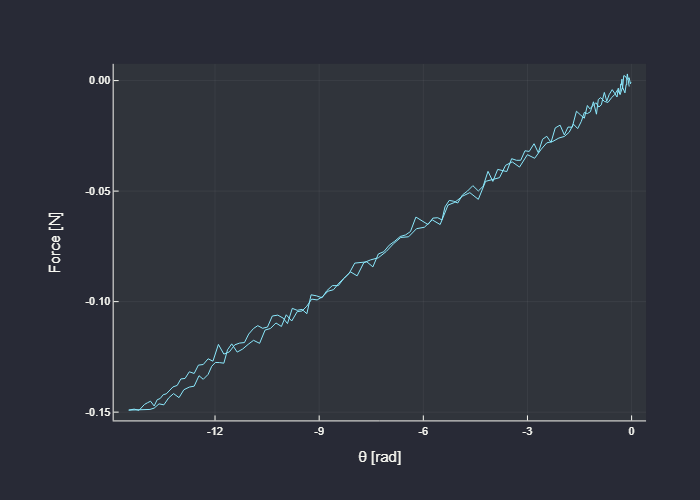

In [202]:
data = CSV.read("data.csv", DataFrame)

data = data[data[!,1] .> -0.15,:]

plot(data[!,2],data[!,1], 
	xlabel = "θ [rad]", 
	ylabel = "Force [N]", 
	labels =:none)

### Gögn 2, Mæling á θ yfir tíma með málmskífu
Með hápunktum og y-ás hliðraður

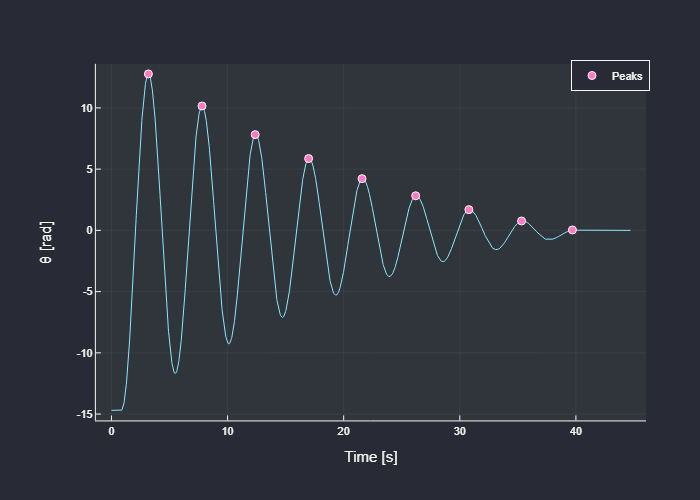

In [203]:
data2 = CSV.read("data2.csv", DataFrame)

data2[!,2] = data2[!,2] .- data2[end,2]

plot(data2[!,1], data2[!,2], 
	xlabel = "Time [s]",
	ylabel = "θ [rad]",
	labels = :none)

peaks = findmaxima(data2[!,2])
peaks = peaks[1][peaks[2] .> -10]

scatter!(data2[peaks,1],data2[peaks,2],
		labels = "Peaks")

#### Gögn 2 nema abs

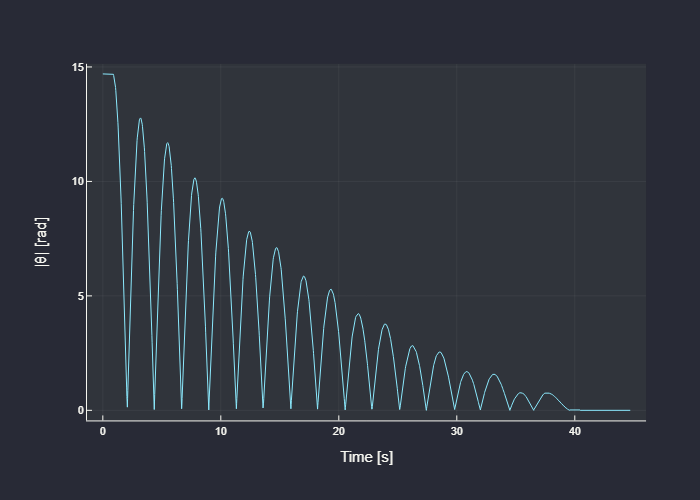

In [204]:
plot(data2[!,1], abs.(data2[!,2]),
xlabel = "Time [s]",
ylab = "|θ| [rad]",
labels = :none)

#### Gögn 2 hápunktar nema $\log_e$ skali á y-ás

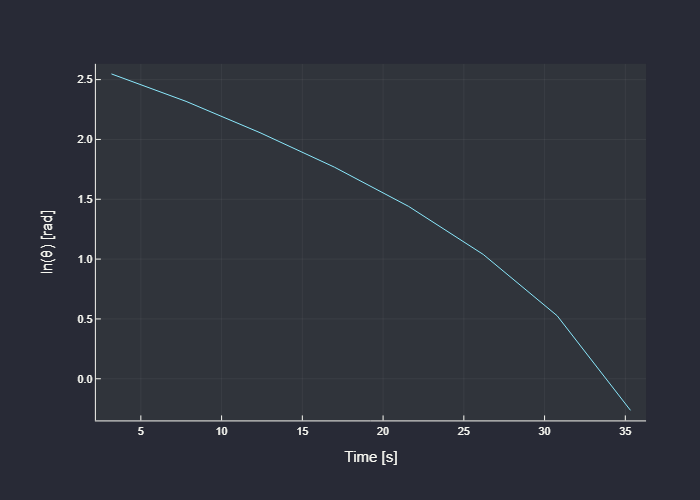

In [205]:
plot(data2[peaks[1:end-1],1], log.(data2[peaks[1:end-1],2]),
xlabel = "Time [s]",
ylabel = "ln(θ) [rad]",
labels = :none)

### Gögn 3, Mæling á θ yfir tíma nema með segul á topp súlunar

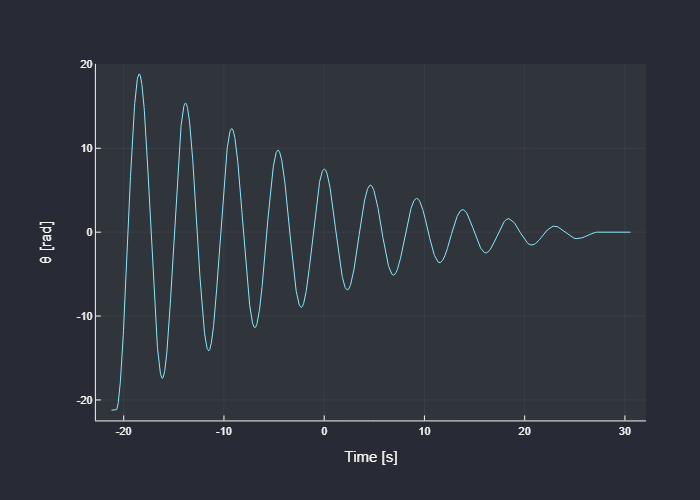

In [206]:
data3 = CSV.read("data3.csv", DataFrame)
data3 = data3 .- data3[end,2]

plot(data3[!,1], data3[!,2],
xlabel = "Time [s]",
ylabel = "θ [rad]",
labels = :none)

### Gögn 4, Mæling á θ yfir tíma nema með segul á hlið topp súlunar

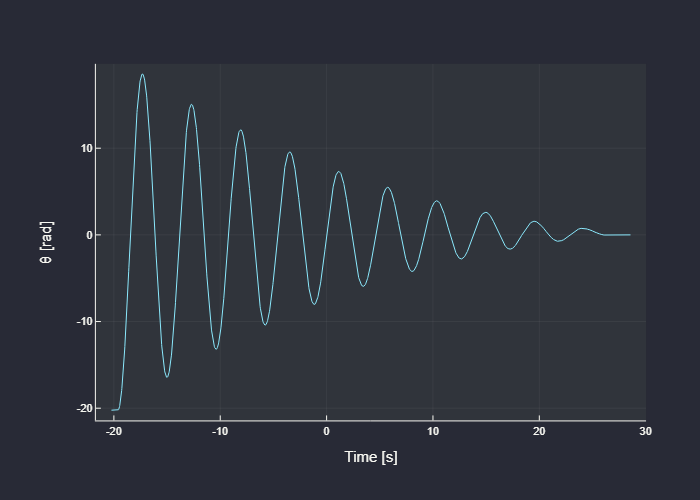

In [207]:
data4 = CSV.read("data4.csv", DataFrame)
data4 = data4 .- data4[end,2]

plot(data4[!,1], data4[!,2],
xlabel = "Time [s]",
ylabel = "θ [rad]",
labels = :none)

## Útreykningar

### Góða gamla fallið

In [208]:
"""
Fall til að fynna jöfnu óvissu fyrir gefna jöfnu
"""
function findErrorFromSym(symExpr; errorPrefix = "Err")
	vars = Symbolics.get_variables(symExpr)
	varErrs = []

	for i in vars
		push!(varErrs, Symbolics.variable(string(errorPrefix,i)))
	end

	Dvars = [expand_derivatives(Differential(i)(symExpr)) for i in vars]

	symErr = sqrt(sum((Dvars[i]*varErrs[i])^2 for i in eachindex(vars)))
	
	return symErr
end

findErrorFromSym

### Mælingar

In [209]:
rskvfull = (5.16±0.01)u"cm"
rskvinn = (0.27±0.01)u"cm"
(rₛ = rskvfull-rskvinn) |> latexify

L"$4.89 ± 0.014 cm$"

In [210]:
(kₛ = fitlinear(data[!,2],data[!,1]).a*1u"N*m") |> latexify

L"$0.01057874813701586 m N$"

In [211]:
(r = (9.5±.1)u"cm") |> latexify

L"$9.5 ± 0.1 cm$"

In [212]:
(m = (122±1)u"g")|> latexify

L"$122.0 ± 1.0 g$"

### Jöfnur og útreikningar

In [213]:
k = fitlinear(data2[peaks,1],log.(ℯ, data2[peaks,2]))


 ------------------- Linear Fit ------------- 

 Equation: y = ax + b 

 With: a = -0.1275172872576596
       b = 3.645453936918476

 Pearson correlation coefficient, R = 0.8749555892893658
 Average square residue = 0.695718033797647

 Predicted Y: ypred = [3.2399489634391183, 2.650819096308731...
 residues = [0.6924588273493502, 0.33265597335136654...

 -------------------------------------------- 


#### Δk

In [214]:
latexify(:(Δk=sqrt(n/(n*sum(x.^2)-sum(x.^2)))),env = :eq)

L"\begin{equation}
{\Delta}k = \sqrt{\frac{n}{n \cdot \sum x^{2} - \sum x^{2}}}
\end{equation}
"

In [215]:
x = data2[peaks,1]
n = length(x)
(Δk = sqrt(n/(n*sum(x.^2)-sum(x.^2)))) |> latexify

L"$0.014386314296074681$"

#### b og Δb

In [216]:
@variables κ R M Δκ ΔR ΔM
b = -1/2 *M*R^2*κ

-0.5M*κ*(R^2)

In [217]:
Δb = findErrorFromSym(b,errorPrefix = "Δ")

sqrt(0.25(M^2)*(R^4)*(Δκ^2) + 0.25(R^4)*(ΔM^2)*(κ^2) + (M^2)*(R^2)*(ΔR^2)*(κ^2))

In [218]:
b= substitute(b, 
	Dict([
		κ => k.a, 
		R => val(r), 
		M => val(m)
	]))
b = b.val

Δb = substitute(Δb, 
	Dict([
		κ => k.a, 
		M => val(m), 
		R => val(r), 
		Δκ => Δk, 
		ΔM => err(m), 
		ΔR => err(r)
	])
)
Δb = Δb.val

(b = (b ± Δb)*u"kg * m^2 * s^-1") |> latexify

L"$7.02e-5 ± 8.1e-6 kg m^2 s^-1$"

#### T og ΔT

In [219]:
I = 0.5*m*r^2
(T = 2π/sqrt(kₛ/I-b^2/4I^2)) |> latexify

L"$1.433 ± 0.016 s$"

In [220]:
@variables K i B ΔK Δi ΔB
t = 2π/sqrt(K/i-B^2/4i^2)
Δt = findErrorFromSym(t,errorPrefix = "Δ")

sqrt((((-1//2)*ΔK*(6.283185307179586 / (sqrt(K / i + (-(B^2)) / (4(i^2)))^2))*(sqrt(K / i + (-(B^2)) / (4(i^2)))^-1)) / i)^2 + ((B*ΔB*(6.283185307179586 / (sqrt(K / i + (-(B^2)) / (4(i^2)))^2))*(sqrt(K / i + (-(B^2)) / (4(i^2)))^-1)) / (4(i^2)))^2 + (1//4)*(Δi^2)*(((-K) / (i^2) - 8i*((-(B^2)) / (16(i^4))))^2)*((6.283185307179586 / (sqrt(K / i + (-(B^2)) / (4(i^2)))^2))^2)*(sqrt(K / i + (-(B^2)) / (4(i^2)))^-2))

In [221]:
Δt = substitute(Δt,
	Dict([
		K => val(kₛ),
		i => val(I),
		B => val(b),
		ΔK => err(kₛ),
		Δi => err(I),
		ΔB => err(b),
		
	])
)

(T = (val(T) ± Δt.val)*1u"s") |> latexify

L"$1.433 ± 0.016 s$"

**↑ Obviously wrong**

**↓ Näive approach**

In [224]:
Ts = mean(diff(data2[peaks,1]))u"s"
Ts = Ts ± maximum(abs.((diff∘diff)(data2[peaks,1])))u"s"
(bs = sqrt(-(16π^2*I^2-4kₛ*Ts^2*I)/T^2)) |> latexify

L"$0.01459 ± 0.00061 kg m^2 s^-1$"

In [225]:
@variables K i t ΔK Δi Δt
B = sqrt(-(16π^2*i^2-4K*t^2*i)/t^2)
ΔB = findErrorFromSym(B, errorPrefix = "Δ")
ΔB = substitute(ΔB, 
	Dict([
		K => val(kₛ),
		i => val(I),
		t => val(Ts),
		ΔK => err(kₛ),
		Δi => err(I),
		Δt => err(Ts)
	])
)
ΔB = ΔB.val
ΔB = ΔB*1u"kg*m^2*s^-1"
(bs = val(bs) ± ΔB.val) |> latexify

L"$0.014593 ± 4.9e-5$"